In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
np.seterr(divide='ignore')

data = pd.read_csv('C:/Users/david/Desktop/maturitni prace/data_analysis_python/eff_october.csv', sep=',', header=None)

names = []
energy = np.array([])
eff = np.array([])
#print(data)

In [2]:
yerr = []
for i in range(3):
    names.append(data[i][0])
for j in range(1,31):
    eff = np.append(eff, float(data[0][j]))
    yerr = np.append(yerr, float(data[1][j]))
    energy = np.append(energy, float(data[2][j]))

In [3]:
def func(x, a, b, c, d, e, f):
    return a * np.log(x)+ b * pow(np.log(x), 2) + c * pow(np.log(x), 3) + d * pow(np.log(x), 4) + e *pow(np.log(x), 5) + f

def linear(x, a, b):
    return a * (x) + b

a0 = -4.122191 +- 0.7323317 (17 %)
a1 = 1.620808 +- 0.2766304 (17 %)
a2 = -0.312858 +- 0.0518798 (16 %)
a3 = 0.029710 +- 0.0048319 (16 %)
a4 = -0.001113 +- 0.0001788 (16 %)
a5 = 4.112870 +- 0.7698687 (18 %)


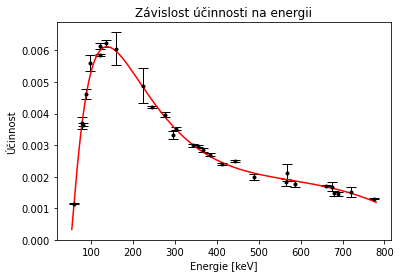

In [4]:

for i in range(1):#sloupce 5
    output = []
    pars, cov = curve_fit(f=func, xdata=energy, ydata=eff, sigma=1./(np.log((yerr*eff))**2))
    coeff_err = np.sqrt(np.diag(cov))
    for i in range(len(pars)):
        output.append('a{0} = {1:.6f} +- {2:.7f} ({3:d} %)'.format(i, pars[i], coeff_err[i], abs(int(coeff_err[i]/pars[i]*100))))

    for i in output:
        print(i)
        
    global eff_param
    eff_param = pars

    #plotovani
    p = np.linspace(min(energy)-5, max(energy)+5, 100000)
    plt.errorbar(energy, eff, yerr=yerr, fmt=".", elinewidth=1, capsize=5, ecolor='black',color='black')
    plt.plot(p, func(p, *pars), c="red")
    plt.ylabel("Účinnost")
    plt.xlabel("Energie [keV]")
    plt.ylim(ymin=0)#omezeni aby vykreslovalo jen kladna y

In [14]:
print(func(185.712, *eff_param))
print(func(766.38, *eff_param))

0.005579466012117784
0.0012628411273754026


# parameters:
* a0 = -4.133349 +- 0.6703348 (16 %) 
* a1 = 1.625515 +- 0.2530204 (15 %)
* a2 = -0.313862 +- 0.0474190 (15 %)
* a3 = 0.029817 +- 0.0044139 (14 %)
* a4 = -0.001117 +- 0.0001633 (14 %)
* a5 = 4.123716 +- 0.7052136 (17 %)

$$
I =  I_0 \cdot e^{masscoef * neco}
$$
kde
$masscoeff * neco $ musi byt beztrozmerne,  I je zareni ktere zmerime na detektoru
potom
$$
neco [cm^{-2}g] \implies density [cm^{-3}g] * height [cm]
$$

In [20]:
file1 = open(r'C:\Users\david\Desktop\maturitni_prace\UmassCoefff.txt', 'r')
#soubor skopirovaných dat z https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z92.html
energy_as_x_to_masscoeff = [] #MeV
masscoef_U = [] #(cm2/g)
v1_density = 18.37414276 #g/cm3
v1_height =  9.99 / 10 #cm

for line in file1:
    energy_as_x_to_masscoeff.append(float(line[3:14]))
    masscoef_U.append(float(line[15:25]))

In [6]:
def exp(masscoeff, density, height):
    x = masscoeff * density * height
    return np.exp(x)

In [15]:
#v tabulce jsem hodnoty ktere jsem použil vyznačil fialově

def calculate_correct_area(energy_of_U, area_of_U):
    '''energy in MeV'''
    area_of_U = energy_of_U / func(energy_of_U*1000, *eff_param)#preopocita plochu dle effektivity

    for k in range(len(energy_as_x_to_masscoeff)):
        #hledam nejbizsi hodnoty
        eng = energy_as_x_to_masscoeff[k]
        if eng > energy_of_U:
            pars, cov = curve_fit(f=linear, xdata=[last_eng, eng], ydata=[masscoef_U[k-1], masscoef_U[k]])
            #udelám usecku mezi nejblizismi hodnotami a dopocitam si hodnotu kterou potrebuji
            masscoef_of_U = linear(energy_of_U, *pars)
            #print("masscoef from linear aprroxiamtion of function of absorbtion is: {}".format(masscoef_of_U))
            print(masscoef_of_U) #dopočítaná hodnota mass coeficientu
            #print(area_of_U * exp(masscoef_of_U, v1_density, v1_height))
            return area_of_U * exp(masscoef_of_U, v1_density, v1_height)
        last_eng = eng

u235 = calculate_correct_area(0.185835, 169587.2)


1.6643068999999997


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [16]:
th234 = calculate_correct_area(0.76638, 98381.6)

0.10956794


In [9]:
#normalize by intensity
U235 = u235/0.572 #je to thorium nebo proaktinum??
TH234 = th234/0.00294
U238 = TH234 * 67715228215.76763    #half lifi of u = 1.4099935680000002e+17, th = 2082240, constant is u/th

In [10]:
enrichment = U235/ (U235 + U238)
print(enrichment)

0.010221091906996172


In [17]:
def peaks_to_enrichment(energy_U235, area_U235, energy_Th, area_Th):
    '''energy is in keV'''
    u235 = calculate_correct_area(energy_U235/1000, area_U235)
    th234 = calculate_correct_area(energy_Th/1000, area_Th)
    U235 = u235/0.572 #je to thorium nebo proaktinum??
    TH234 = th234/0.00294
    U238 = TH234 * 67715228215.76763    #half lifi of u = 1.4099935680000002e+17, th = 2082240, constant is u/th
    enrichment = U235/ (U235 + U238)
    return enrichment

print("enrichment of first samlpe is: {} %".format(peaks_to_enrichment(185.835, 169587.2, 766.38, 98381.6)*100))
print("enrichment of second samlpe is: {} %".format(peaks_to_enrichment(185.835, 42803.8, 766.38, 24672.3)*100))
print("enrichment of 3th samlpe is: {} %".format(peaks_to_enrichment(185.835, 40608.2, 766.38, 12506.7)*100))
print("enrichment of 4th samlpe is: {} %".format(peaks_to_enrichment(185.835, 86737.1, 766.38, 26741)*100))
#something is wrong, i can feel it

1.6643068999999997
0.10956794
enrichment of first samlpe is: 99.9999998569939 %
1.6643068999999997
0.10956794
enrichment of second samlpe is: 99.9999998569939 %
1.6643068999999997
0.10956794
enrichment of 3th samlpe is: 99.9999998569939 %
1.6643068999999997
0.10956794
enrichment of 4th samlpe is: 99.9999998569939 %


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


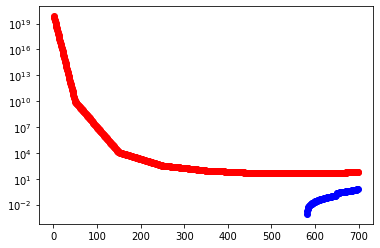

In [12]:
#debug
a = []
xs = range(1, 700)
for dx in xs:
    a.append(calculate_correct_area(0.150+(dx/1000), 10)/100)
    if calculate_correct_area(0.150+dx/1000, 1000) < 0:
        print("eneded at energy {}".format(0.150+dx/1000))
        break

#print(a)
b = []
bs = range(1, len(a))
for i in bs:
    b.append(a[i] - a[i-1])

#print(b)

#plotovani
plt.scatter(xs, a, c="r")
plt.scatter(bs, b, c="b")
plt.yscale('log')
#jej to sedi (asi) to by melo fungovat


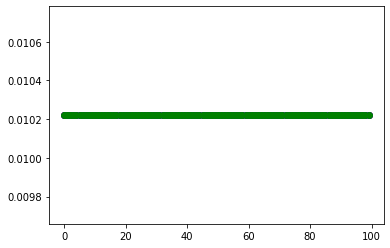

In [13]:
x = range(100)
x0 = 169587
y = range(100)
y0 = 98381
z0 = []
z1 = []
z2 = []

for i in range(100):
    z0.append(peaks_to_enrichment(185.835, i * 100, 766.38, y0))
    z1.append(peaks_to_enrichment(185.835, x0, 766.38, i * 100))
    z2.append(peaks_to_enrichment(185.835, i * 100, 766.38, i * 100))


plt.scatter(x, z0, c="r")
plt.scatter(x, z1, c="b")
plt.scatter(x, z1, c="g")
#dukaz toho ze nezavisi na plose...

In [30]:
def calculate_absorbtion(energy, coeff = masscoef_U, energy_x_values = energy_as_x_to_masscoeff, D = v1_height, density = v1_density):
    energy = energy/1000
    for k in range(len(energy_x_values)):
        eng = energy_x_values[k]
        if eng > energy:
            pars, cov = curve_fit(f=linear, xdata=[last_eng, eng], ydata=[masscoef_U[k-1], masscoef_U[k]])
            masscoef_of_U = linear(energy, *pars)
            #print(masscoef_of_U)
            return (masscoef_of_U * D)/(1 - np.exp(-(masscoef_of_U * D)))

        last_eng = eng

print(calculate_absorbtion(185.712))
print(calculate_absorbtion(766.38))

2.054122335461702
1.055727414649691
